In [277]:
from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = '0347fe1d-150a-4ad7-9244-9069a9b25839'
config.sh_client_id = '470b0865-7123-4b24-a062-cec503e427d8'
config.sh_client_secret = 'x~!ad,O(CGi?q(Bp~:OM395]_;HeO1/*?))}!+1W'
config.download_timeout_seconds = 1200
config.save()
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [278]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [279]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    parse_time,
)

In [280]:
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

In [281]:
import geopandas as gpd
polygon = gpd.read_file('agri_12.geojson')
#polygon.geometry.values[0]
#for plot in polygon.geometry.values:



In [282]:
with open("statapi_evalscript.js", "r") as fp:
    features_evalscript = fp.read()

In [283]:
yearly_time_interval = "2015-01-01", "2022-12-31"

aggregation = SentinelHubStatistical.aggregation(
    evalscript=features_evalscript, time_interval=yearly_time_interval, aggregation_interval="P1D", resolution=(10, 10) 
)

calculations = {"default": {"statistics": {"default": {"percentiles": {"k": [5, 50, 95]}}}}}

'''
request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L2A)],
        geometry=Geometry(polygon.geometry.values[0], crs=CRS(polygon.crs)),
        calculations=calculations,
        config=config,
    ) 
'''

features_requests = []
for geo_shape in polygon.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L2A)],
        geometry=Geometry(geo_shape, crs=CRS(polygon.crs)),
        calculations=calculations,
        config=config,
    )

    features_requests.append(request)
    


c:\Users\xiemp\anaconda3\lib\site-packages\sentinelhub\constants.py:126: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [284]:
'''
client = SentinelHubStatisticalDownloadClient(config=config)

features_stats = client.download(request.download_list[0])

len(features_stats)
'''

download_requests = [request.download_list[0] for request in features_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

features_stats = client.download(download_requests)

len(features_stats)


9

In [285]:
#print(features_stats[0])

In [286]:
#ndvi_df = stats_to_df(features_stats)

ndvi_df = [stats_to_df(polygon_stats) for polygon_stats in features_stats]

for df, land_type in zip(ndvi_df, polygon["name"].values):
    df["name"] = land_type

ndvi_df = pd.concat(ndvi_df)

In [287]:
BANDS = DataCollection.SENTINEL2_L2A.bands
INDICES = ["NDVI", "NDVI_RE1", "NBSI", "CLP"]
STATISTICAL_QUANTITIES = ["mean", "min", "max", "stDev", "percentiles_5.0", "percentiles_50.0", "percentiles_95.0"]


for band in BANDS:
    for stat in STATISTICAL_QUANTITIES:
        column_name = f"bands_{band.name}_{stat}"
        column = ndvi_df[column_name]

        column = column / 10000.0

        ndvi_df[column_name] = column
        

for index in INDICES:
    for stat in STATISTICAL_QUANTITIES:
        column_name = f"indices_{index}_{stat}"
        column = ndvi_df[column_name]

        if stat == "stDev":
            column = column / 5000.0
        else:
            column = (column - 5000.0) / 5000.0

        ndvi_df[column_name] = column


KeyError: 'indices_NDWI_mean'

<AxesSubplot:xlabel='interval_from'>

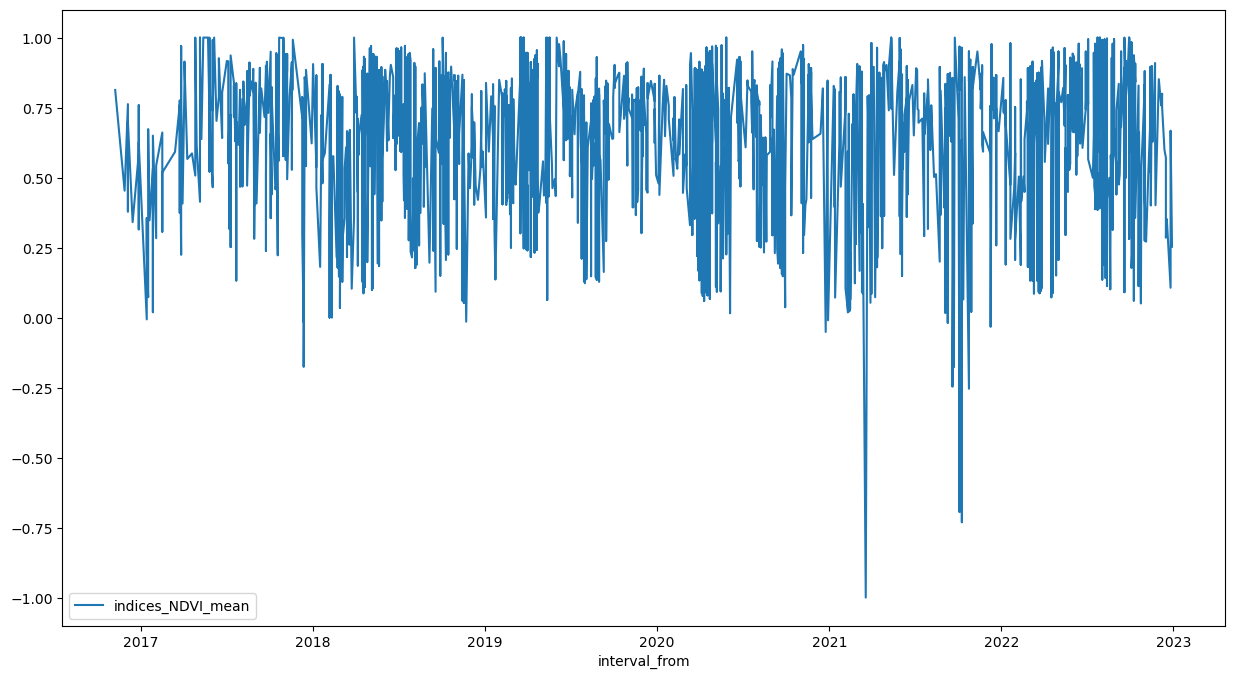

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

ndvi_df.plot(ax=ax, x="interval_from", y="indices_NDVI_mean")

In [ ]:
ndvi_df.to_csv('agri_12.csv')